## Environment setup

### Configure your API keys

To download YOLOE weights, you need to provide your HuggingFace Token. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- In Colab, go to the left pane and click on `Secrets` (🔑). tore HuggingFace Access Token under the name `HF_TOKEN`.

### Install dependencies

In [1]:
# !pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
# !pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
# !pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
# !pip install -q "git+https://github.com/THU-MIG/yoloe.git"

# !pip install -q supervision jupyter_bbox_widget

# !wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

In [2]:
# For mutilple images support, install from branch mutli-source-predict-vp

# !pip install -q "git+https://github.com/THU-MIG/yoloe.git@multi-source-predict-vp"
# !pip install -q --force-reinstall "git+https://github.com/THU-MIG/yoloe.git@multi-source-predict-vp"

### Pull weights

In [3]:
# from huggingface_hub import hf_hub_download

# path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
# path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

In [1]:
import os
id = 2
os.environ['CUDA_VISIBLE_DEVICES'] = str(id)

In [2]:
from tempfile import mkdtemp
from yoloe_utils import *

## Prompt free

In [3]:
# !wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [7]:
model = YOLOE("pretrain/yoloe-v8l-seg-pf.pt").cuda()

# planet imagery
# IMAGE_PATH = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/source.jpg'
# zebra image
IMAGE_PATH = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/PaliGemma/ztemp/images/zebra.jpg'
image = Image.open(IMAGE_PATH)
result = model.predict(image, conf = 0.1)
detections = sv.Detections.from_ultralytics(result[0])
annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator(text_scale=0.5, text_thickness=1, text_position= Position.BOTTOM_CENTER).annotate(scene=annotated_image, detections=detections)
print(detections.data)
# annotated_image


0: 640x640 1 ecosystem, 1 field, 3 horses, 1 grassland, 1 jungle, 2 manes, 2 plantations, 3 tails, 1 trio, 1 winter morning, 2 zebras, 15.9ms
Speed: 3.6ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
{'class_name': array(['zebra', 'horse', 'zebra', 'horse', 'horse', 'field', 'grassland', 'jungle', 'plantation', 'ecosystem', 'mane', 'mane', 'trio', 'tail', 'winter morning', 'tail', 'tail', 'plantation'], dtype='<U14')}


In [ ]:
# GMS imagery
gt_image_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/images'
gt_label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/labels'

## class information in yml file 
data_yml_save_path=mkdtemp()
data_yml = f"""train: dummy
val: dummy
nc: 1
names: ["brick kilns with chimney"]
"""
data_yml_path = f"{data_yml_save_path}/data.yml"
with open(data_yml_path, "w") as f:
    f.write(data_yml)

print(data_yml_path) 

## Supervision dataset
sv_dataset=sv.DetectionDataset.from_yolo(gt_image_dir,gt_label_dir,data_yml_path,is_obb=True)
CLASSES = sv_dataset.classes
class_mapping = create_class_mapping(CLASSES, is_dota_dataset = False)

targets = []
predictions = []
images = []

for classes, image, gt_detection in sv_dataset:
    result = model.predict(image, conf = 0.25)
    detections = sv.Detections.from_ultralytics(result[0])
    detections = add_class_ids(detections, CLASSES, class_mapping)
    
    targets.append(gt_detection)
    predictions.append(detections)
    images.append(image)

map_result, map_result_50, map_result_50_95 = calculate_map(predictions, targets)
df = calculate_confusion_matrix(predictions, targets, CLASSES, map_result)
display(df)
# visualize_predictions(images, predictions, targets, start = 0, end = 25, rows =5, cols = 5)

## Text prompt for image processing

In [ ]:
NAMES = ['zebra']

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))
result = model.predict(image, conf = 0.25)
detections = sv.Detections.from_ultralytics(result[0])
print(detections)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(image)

for i in range(len(detections.xyxy)):
    xmin, ymin, xmax, ymax = detections.xyxy[i]
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))

ax.set_axis_off()

In [ ]:
# IMAGE_PATH = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/images/*'))[0]
# IMAGE_PATH = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/test_superresolved/images/*'))[0]

NAMES = ['brick kilns with chimney']

model = YOLOE("yoloe-v8l-seg.pt").cuda()
# model = YOLOE("/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/runs/lp/train/weights/best.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

gt_image_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/images'
gt_label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/labels'

## class information in yml file 
data_yml_save_path=mkdtemp()
data_yml = f"""train: dummy
val: dummy
nc: 1
names: ["brick kilns with chimney"]
"""
data_yml_path = f"{data_yml_save_path}/data.yml"
with open(data_yml_path, "w") as f:
    f.write(data_yml)

print(data_yml_path) 

## Supervision dataset
sv_dataset=sv.DetectionDataset.from_yolo(gt_image_dir,gt_label_dir,data_yml_path,is_obb=True)
CLASSES = sv_dataset.classes
class_mapping = create_class_mapping(CLASSES, is_dota_dataset = False)

targets = []
predictions = []
images = []

for classes, image, gt_detection in sv_dataset:
    result = model.predict(image, conf = 0.25)
    detections = sv.Detections.from_ultralytics(result[0])
    detections = add_class_ids(detections, CLASSES, class_mapping)
    
    targets.append(gt_detection)
    predictions.append(detections)
    images.append(image)

map_result, map_result_50, map_result_50_95 = calculate_map(predictions, targets)
df = calculate_confusion_matrix(predictions, targets, CLASSES, map_result)
display(df)
visualize_predictions(images, predictions, targets, start = 0, end = 25, rows =5, cols = 5)

## Visual prompt for image processing

#### Lucknow 
- /home/patel_zeel/kiln_compass_24/data/lucknow_airshed/images/9021406_3118628.tif  # has maximum number of kilns (8 kilns)
- /home/patel_zeel/kiln_compass_24/data/lucknow_airshed/images/9007647_3088359.tif # all kiln classes are present (5 kilns)

#### West Bengal
- /home/patel_zeel/kiln_compass_24/data/west_bengal/images/9850595_2774661.tif # has maximum number of kilns (9 kilns)

#### Uttar Pradesh
- /home/patel_zeel/kiln_compass_24/data/uttar_pradesh/images/8652062_3224111.tif # has maximum number of kilns (13 kilns) all kiln classes are present (13 kilns)

**NOTE:** `YOLOEVPSegPredictor` takes `np.ndarray` box prompt in `[x_min, y_min, x_max, y_max]` format.

In [11]:
# training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train'
training_set_path = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/train'
dynamic_dir = '../dynamic_train'
type = 'png' # png, tif

# test_image_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/images' # west_bengal_small_639_sq_km, lucknow_small_600_sq_km
# test_label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/lucknow_small_600_sq_km/kiln_images/test/labels'

test_image_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test_with_background_images/images'
test_label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test_with_background_images/labels'

## class information in yml file 
data_yml_save_path=mkdtemp()
data_yml = f"""train: dummy
val: dummy
nc: 1
names: ["brick kilns with chimney"]
"""
data_yml_path = f"{data_yml_save_path}/data.yml"
with open(data_yml_path, "w") as f:
    f.write(data_yml)

print(data_yml_path) 

## Supervision dataset
sv_dataset=sv.DetectionDataset.from_yolo(test_image_dir,test_label_dir,data_yml_path,is_obb=True)
CLASSES = sv_dataset.classes
class_mapping = create_class_mapping(CLASSES, is_dota_dataset = False)

/tmp/tmp614_bub_/data.yml


#### visual prompt of multiple images


0: 640x640 2 object0s, 337.7ms
Speed: 22.7ms preprocess, 337.7ms inference, 962.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.0ms
Speed: 1.9ms preprocess, 18.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.5ms
Speed: 1.8ms preprocess, 16.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.3ms
Speed: 1.8ms preprocess, 16.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.9ms
Speed: 2.1ms preprocess, 26.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.3ms
Speed: 1.7ms preprocess, 15.3ms i

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.323529,0.354839,0.338462,11.0,23.0,20.0,31.0,0.191122
0,0.3,0.264706,0.290323,0.276923,9.0,25.0,22.0,31.0,0.191122
0,0.5,0.235294,0.258065,0.246154,8.0,26.0,23.0,31.0,0.191122
0,0.7,0.058824,0.064516,0.061538,2.0,32.0,29.0,31.0,0.191122



0: 640x640 2 object0s, 36.1ms
1: 640x640 1 object0, 36.1ms
Speed: 3.1ms preprocess, 36.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 24.9ms
Speed: 1.8ms preprocess, 24.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.9ms
Speed: 2.0ms preprocess, 18.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.5ms
Speed: 2.8ms preprocess, 18.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.0ms
Speed: 1.8ms preprocess, 16.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.6ms
Speed: 1.

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.250000,0.290323,0.268657,9.0,27.0,22.0,31.0,0.213527
0,0.3,0.222222,0.258065,0.238806,8.0,28.0,23.0,31.0,0.213527
0,0.5,0.222222,0.258065,0.238806,8.0,28.0,23.0,31.0,0.213527
0,0.7,0.111111,0.129032,0.119403,4.0,32.0,27.0,31.0,0.213527



0: 640x640 2 object0s, 25.5ms
1: 640x640 1 object0, 25.5ms
2: 640x640 4 object0s, 25.5ms
Speed: 2.4ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.8ms
Speed: 3.4ms preprocess, 18.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 17.9ms
Speed: 1.8ms preprocess, 17.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.9ms
Speed: 1.8ms preprocess, 18.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.5ms
Speed: 2.8ms preprocess, 19.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.1ms
Speed: 2.7ms preprocess, 19.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.197674,0.548387,0.290598,17.0,69.0,14.0,31.0,0.294495
0,0.3,0.174419,0.483871,0.256410,15.0,71.0,16.0,31.0,0.294495
0,0.5,0.151163,0.419355,0.222222,13.0,73.0,18.0,31.0,0.294495
0,0.7,0.069767,0.193548,0.102564,6.0,80.0,25.0,31.0,0.294495



0: 640x640 2 object0s, 18.2ms
1: 640x640 1 object0, 18.2ms
2: 640x640 4 object0s, 18.2ms
3: 640x640 1 object0, 18.2ms
Speed: 3.9ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 24.5ms
Speed: 2.3ms preprocess, 24.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.5ms
Speed: 1.7ms preprocess, 15.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.3ms
Speed: 1.9ms preprocess, 23.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.5ms
Speed: 1.8ms preprocess, 15.5ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.9ms
Speed: 1.7ms preprocess, 18.9ms inference, 0.3ms postprocess per image at shape (1,

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.183333,0.709677,0.291391,22.0,98.0,9.0,31.0,0.356617
0,0.3,0.175000,0.677419,0.278146,21.0,99.0,10.0,31.0,0.356617
0,0.5,0.150000,0.580645,0.238411,18.0,102.0,13.0,31.0,0.356617
0,0.7,0.058333,0.225806,0.092715,7.0,113.0,24.0,31.0,0.356617



0: 640x640 2 object0s, 14.5ms
1: 640x640 1 object0, 14.5ms
2: 640x640 4 object0s, 14.5ms
3: 640x640 1 object0, 14.5ms
4: 640x640 1 object0, 14.5ms
Speed: 2.4ms preprocess, 14.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 25.0ms
Speed: 1.8ms preprocess, 25.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.4ms
Speed: 1.8ms preprocess, 16.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.0ms
Speed: 1.8ms preprocess, 18.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 brick kilns with chimney, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.2ms
Speed: 2.1ms preprocess, 16.2ms inference, 

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.137056,0.870968,0.236842,27.0,170.0,4.0,31.0,0.399522
0,0.3,0.126904,0.806452,0.219298,25.0,172.0,6.0,31.0,0.399522
0,0.5,0.106599,0.677419,0.184211,21.0,176.0,10.0,31.0,0.399522
0,0.7,0.040609,0.258065,0.070175,8.0,189.0,23.0,31.0,0.399522



0: 640x640 2 object0s, 11.0ms
1: 640x640 1 object0, 11.0ms
2: 640x640 4 object0s, 11.0ms
3: 640x640 1 object0, 11.0ms
4: 640x640 1 object0, 11.0ms
5: 640x640 1 object0, 11.0ms
6: 640x640 1 object0, 11.0ms
Speed: 4.2ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 15.3ms
Speed: 2.1ms preprocess, 15.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.0ms
Speed: 1.8ms preprocess, 26.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 16.2ms
Speed: 1.8ms preprocess, 16.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 23.3ms
Speed: 1.8ms preprocess, 23.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 brick kilns with chimney, 25.9ms
Speed: 1.8ms preprocess, 25.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detec

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.132979,0.806452,0.228311,25.0,163.0,6.0,31.0,0.402106
0,0.3,0.132979,0.806452,0.228311,25.0,163.0,6.0,31.0,0.402106
0,0.5,0.111702,0.677419,0.191781,21.0,167.0,10.0,31.0,0.402106
0,0.7,0.058511,0.354839,0.100457,11.0,177.0,20.0,31.0,0.402106



0: 640x640 2 object0s, 9.1ms
1: 640x640 1 object0, 9.1ms
2: 640x640 4 object0s, 9.1ms
3: 640x640 1 object0, 9.1ms
4: 640x640 1 object0, 9.1ms
5: 640x640 1 object0, 9.1ms
6: 640x640 1 object0, 9.1ms
7: 640x640 1 object0, 9.1ms
8: 640x640 2 object0s, 9.1ms
9: 640x640 1 object0, 9.1ms
Speed: 3.7ms preprocess, 9.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.2ms
Speed: 2.9ms preprocess, 20.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 21.3ms
Speed: 2.1ms preprocess, 21.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 brick kilns with chimney, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 18.6ms
Speed: 1.8ms preprocess, 18.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 brick kilns with chimney, 16.5ms
Speed: 2.4ms preprocess, 16.5m

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.098246,0.903226,0.177215,28.0,257.0,3.0,31.0,0.451406
0,0.3,0.098246,0.903226,0.177215,28.0,257.0,3.0,31.0,0.451406
0,0.5,0.087719,0.806452,0.158228,25.0,260.0,6.0,31.0,0.451406
0,0.7,0.045614,0.419355,0.082278,13.0,272.0,18.0,31.0,0.451406



0: 640x640 2 object0s, 7.9ms
1: 640x640 1 object0, 7.9ms
2: 640x640 4 object0s, 7.9ms
3: 640x640 1 object0, 7.9ms
4: 640x640 1 object0, 7.9ms
5: 640x640 1 object0, 7.9ms
6: 640x640 1 object0, 7.9ms
7: 640x640 1 object0, 7.9ms
8: 640x640 2 object0s, 7.9ms
9: 640x640 1 object0, 7.9ms
10: 640x640 (no detections), 7.9ms
11: 640x640 3 object0s, 7.9ms
12: 640x640 (no detections), 7.9ms
13: 640x640 2 object0s, 7.9ms
14: 640x640 3 object0s, 7.9ms
15: 640x640 (no detections), 7.9ms
16: 640x640 1 object0, 7.9ms
17: 640x640 2 object0s, 7.9ms
18: 640x640 1 object0, 7.9ms
19: 640x640 (no detections), 7.9ms
Speed: 3.2ms preprocess, 7.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 21.7ms
Speed: 2.4ms preprocess, 21.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.6ms
Speed: 1.7ms preprocess, 19.6ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 26.1ms


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.108209,0.935484,0.193980,29.0,239.0,2.0,31.0,0.474072
0,0.3,0.108209,0.935484,0.193980,29.0,239.0,2.0,31.0,0.474072
0,0.5,0.097015,0.838710,0.173913,26.0,242.0,5.0,31.0,0.474072
0,0.7,0.048507,0.419355,0.086957,13.0,255.0,18.0,31.0,0.474072



0: 640x640 2 object0s, 7.6ms
1: 640x640 1 object0, 7.6ms
2: 640x640 4 object0s, 7.6ms
3: 640x640 1 object0, 7.6ms
4: 640x640 1 object0, 7.6ms
5: 640x640 1 object0, 7.6ms
6: 640x640 1 object0, 7.6ms
7: 640x640 1 object0, 7.6ms
8: 640x640 2 object0s, 7.6ms
9: 640x640 1 object0, 7.6ms
10: 640x640 (no detections), 7.6ms
11: 640x640 3 object0s, 7.6ms
12: 640x640 (no detections), 7.6ms
13: 640x640 2 object0s, 7.6ms
14: 640x640 3 object0s, 7.6ms
15: 640x640 (no detections), 7.6ms
16: 640x640 1 object0, 7.6ms
17: 640x640 2 object0s, 7.6ms
18: 640x640 1 object0, 7.6ms
19: 640x640 (no detections), 7.6ms
20: 640x640 2 object0s, 7.6ms
21: 640x640 1 object0, 7.6ms
22: 640x640 (no detections), 7.6ms
23: 640x640 1 object0, 7.6ms
24: 640x640 1 object0, 7.6ms
25: 640x640 2 object0s, 7.6ms
26: 640x640 2 object0s, 7.6ms
27: 640x640 3 object0s, 7.6ms
28: 640x640 2 object0s, 7.6ms
29: 640x640 2 object0s, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.095385,1.000000,0.174157,31.0,294.0,0.0,31.0,0.496973
0,0.3,0.092308,0.967742,0.168539,30.0,295.0,1.0,31.0,0.496973
0,0.5,0.080000,0.838710,0.146067,26.0,299.0,5.0,31.0,0.496973
0,0.7,0.046154,0.483871,0.084270,15.0,310.0,16.0,31.0,0.496973



0: 640x640 2 object0s, 7.3ms
1: 640x640 1 object0, 7.3ms
2: 640x640 4 object0s, 7.3ms
3: 640x640 1 object0, 7.3ms
4: 640x640 1 object0, 7.3ms
5: 640x640 1 object0, 7.3ms
6: 640x640 1 object0, 7.3ms
7: 640x640 1 object0, 7.3ms
8: 640x640 2 object0s, 7.3ms
9: 640x640 1 object0, 7.3ms
10: 640x640 (no detections), 7.3ms
11: 640x640 3 object0s, 7.3ms
12: 640x640 (no detections), 7.3ms
13: 640x640 2 object0s, 7.3ms
14: 640x640 3 object0s, 7.3ms
15: 640x640 (no detections), 7.3ms
16: 640x640 1 object0, 7.3ms
17: 640x640 2 object0s, 7.3ms
18: 640x640 1 object0, 7.3ms
19: 640x640 (no detections), 7.3ms
20: 640x640 2 object0s, 7.3ms
21: 640x640 1 object0, 7.3ms
22: 640x640 (no detections), 7.3ms
23: 640x640 1 object0, 7.3ms
24: 640x640 1 object0, 7.3ms
25: 640x640 2 object0s, 7.3ms
26: 640x640 2 object0s, 7.3ms
27: 640x640 3 object0s, 7.3ms
28: 640x640 2 object0s, 7.3ms
29: 640x640 2 object0s, 7.3ms
30: 640x640 3 object0s, 7.3ms
31: 640x640 2 object0s, 7.3ms
32: 640x640 1 object0, 7.3ms
33: 640

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.089021,0.967742,0.163043,30.0,307.0,1.0,31.0,0.447628
0,0.3,0.089021,0.967742,0.163043,30.0,307.0,1.0,31.0,0.447628
0,0.5,0.077151,0.838710,0.141304,26.0,311.0,5.0,31.0,0.447628
0,0.7,0.041543,0.451613,0.076087,14.0,323.0,17.0,31.0,0.447628



0: 640x640 2 object0s, 7.6ms
1: 640x640 1 object0, 7.6ms
2: 640x640 4 object0s, 7.6ms
3: 640x640 1 object0, 7.6ms
4: 640x640 1 object0, 7.6ms
5: 640x640 1 object0, 7.6ms
6: 640x640 1 object0, 7.6ms
7: 640x640 1 object0, 7.6ms
8: 640x640 2 object0s, 7.6ms
9: 640x640 1 object0, 7.6ms
10: 640x640 (no detections), 7.6ms
11: 640x640 3 object0s, 7.6ms
12: 640x640 (no detections), 7.6ms
13: 640x640 2 object0s, 7.6ms
14: 640x640 3 object0s, 7.6ms
15: 640x640 (no detections), 7.6ms
16: 640x640 1 object0, 7.6ms
17: 640x640 2 object0s, 7.6ms
18: 640x640 1 object0, 7.6ms
19: 640x640 (no detections), 7.6ms
20: 640x640 2 object0s, 7.6ms
21: 640x640 1 object0, 7.6ms
22: 640x640 (no detections), 7.6ms
23: 640x640 1 object0, 7.6ms
24: 640x640 1 object0, 7.6ms
25: 640x640 2 object0s, 7.6ms
26: 640x640 2 object0s, 7.6ms
27: 640x640 3 object0s, 7.6ms
28: 640x640 2 object0s, 7.6ms
29: 640x640 2 object0s, 7.6ms
30: 640x640 3 object0s, 7.6ms
31: 640x640 2 object0s, 7.6ms
32: 640x640 1 object0, 7.6ms
33: 640

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.088496,0.967742,0.162162,30.0,309.0,1.0,31.0,0.45397
0,0.3,0.085546,0.935484,0.156757,29.0,310.0,2.0,31.0,0.45397
0,0.5,0.073746,0.806452,0.135135,25.0,314.0,6.0,31.0,0.45397
0,0.7,0.041298,0.451613,0.075676,14.0,325.0,17.0,31.0,0.45397



0: 640x640 2 object0s, 7.5ms
1: 640x640 1 object0, 7.5ms
2: 640x640 4 object0s, 7.5ms
3: 640x640 1 object0, 7.5ms
4: 640x640 1 object0, 7.5ms
5: 640x640 1 object0, 7.5ms
6: 640x640 1 object0, 7.5ms
7: 640x640 1 object0, 7.5ms
8: 640x640 2 object0s, 7.5ms
9: 640x640 1 object0, 7.5ms
10: 640x640 (no detections), 7.5ms
11: 640x640 3 object0s, 7.5ms
12: 640x640 (no detections), 7.5ms
13: 640x640 2 object0s, 7.5ms
14: 640x640 3 object0s, 7.5ms
15: 640x640 (no detections), 7.5ms
16: 640x640 1 object0, 7.5ms
17: 640x640 2 object0s, 7.5ms
18: 640x640 1 object0, 7.5ms
19: 640x640 (no detections), 7.5ms
20: 640x640 2 object0s, 7.5ms
21: 640x640 1 object0, 7.5ms
22: 640x640 (no detections), 7.5ms
23: 640x640 1 object0, 7.5ms
24: 640x640 1 object0, 7.5ms
25: 640x640 2 object0s, 7.5ms
26: 640x640 2 object0s, 7.5ms
27: 640x640 3 object0s, 7.5ms
28: 640x640 2 object0s, 7.5ms
29: 640x640 2 object0s, 7.5ms
30: 640x640 3 object0s, 7.5ms
31: 640x640 2 object0s, 7.5ms
32: 640x640 1 object0, 7.5ms
33: 640

,IoU,Precision,Recall,F1 score,TP,FP,FN,Kiln instances,mAP@50
0,0.1,0.098901,0.870968,0.177632,27.0,246.0,4.0,31.0,0.464574
0,0.3,0.091575,0.806452,0.164474,25.0,248.0,6.0,31.0,0.464574
0,0.5,0.087912,0.774194,0.157895,24.0,249.0,7.0,31.0,0.464574
0,0.7,0.047619,0.419355,0.085526,13.0,260.0,18.0,31.0,0.464574


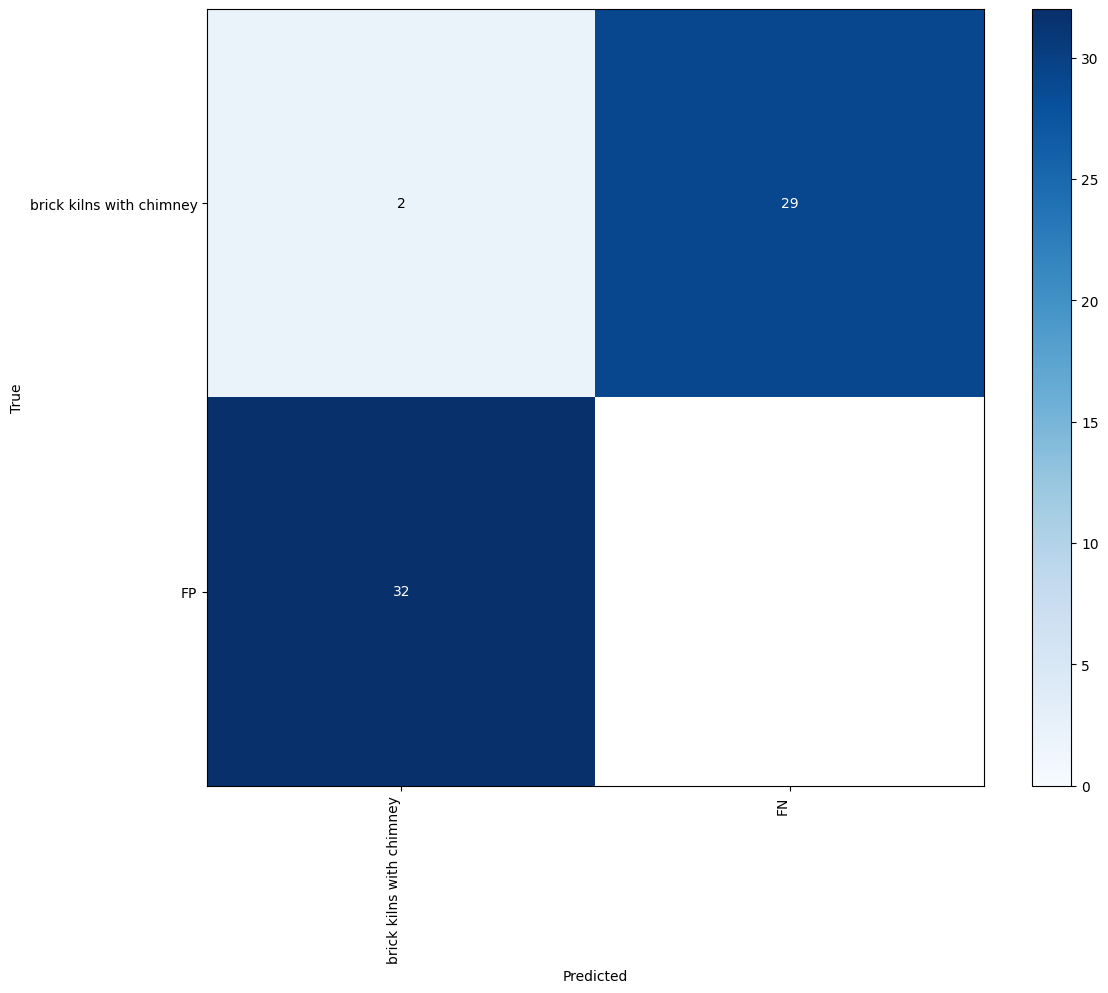

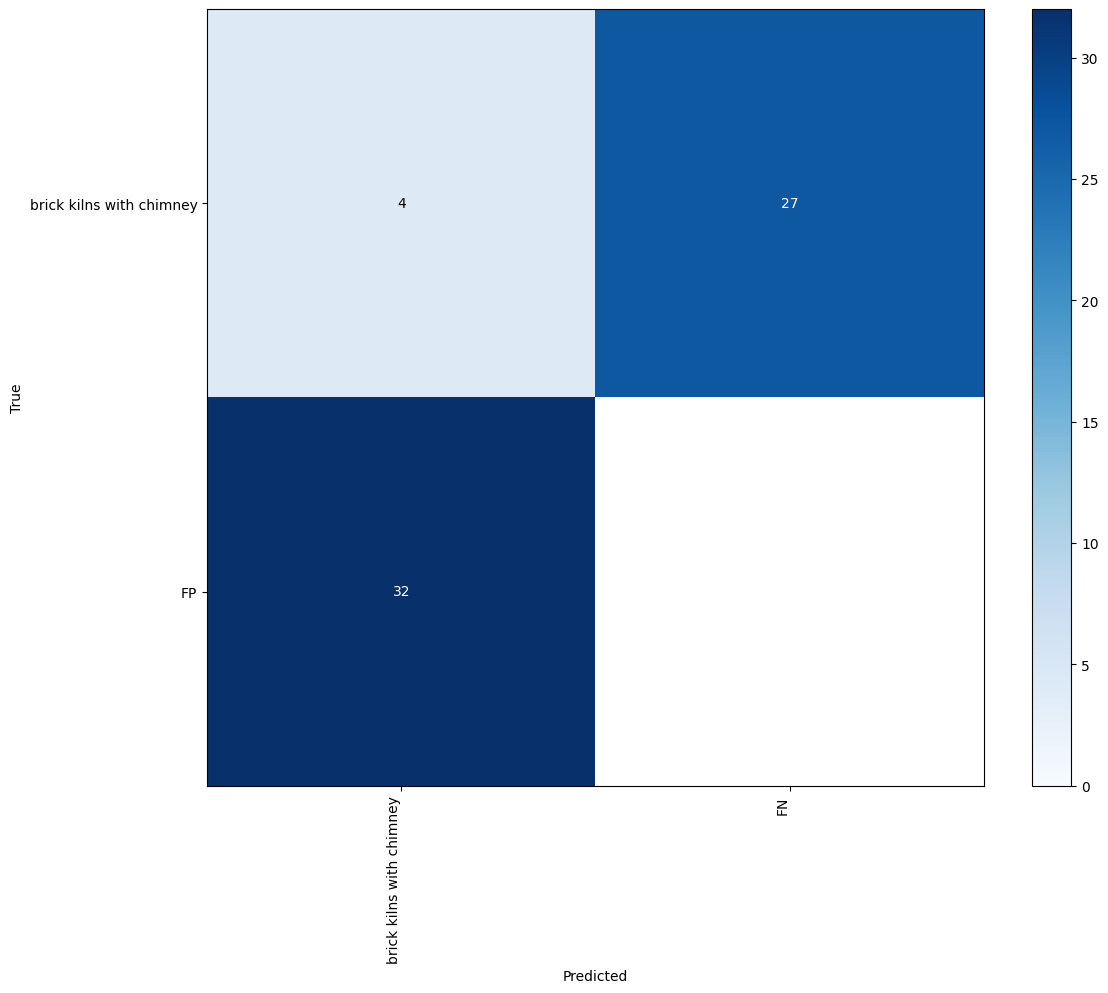

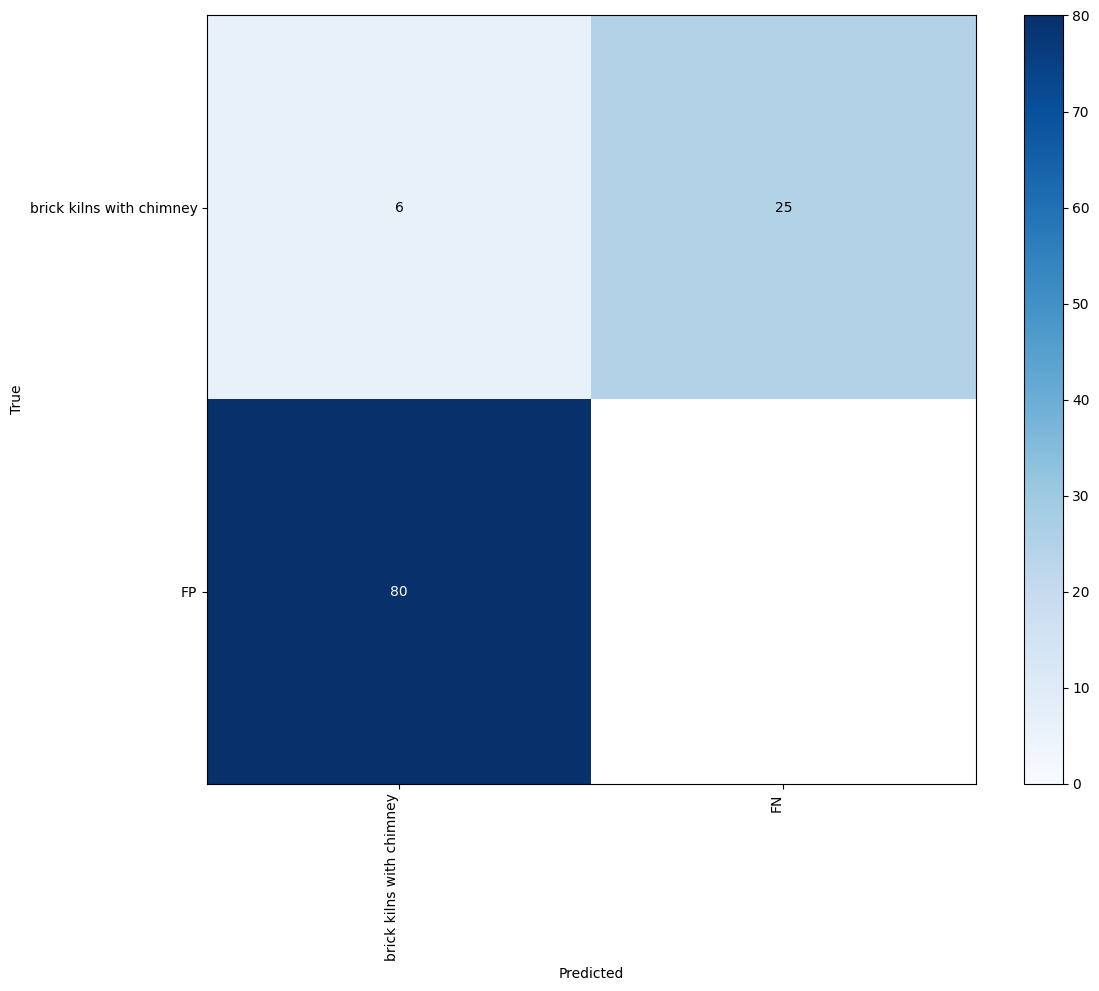

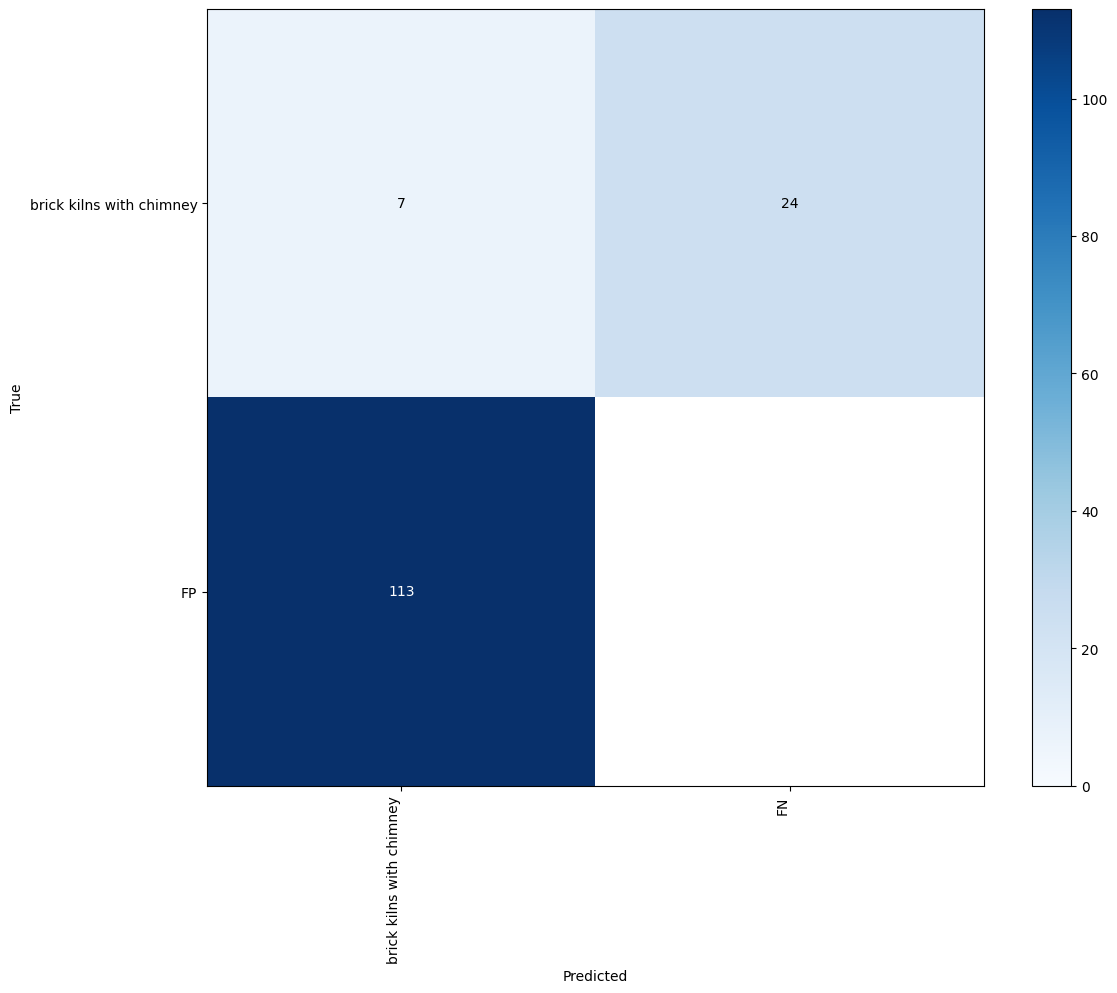

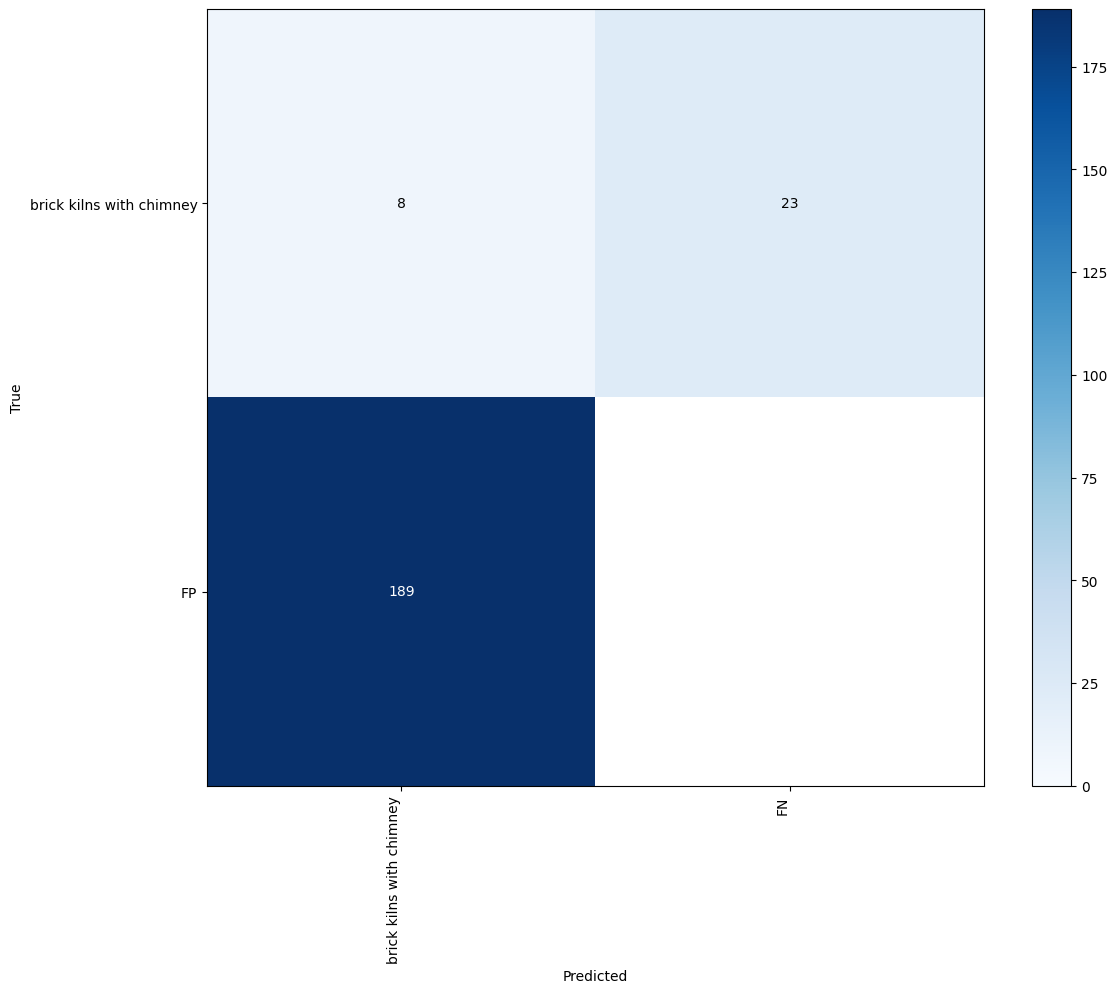

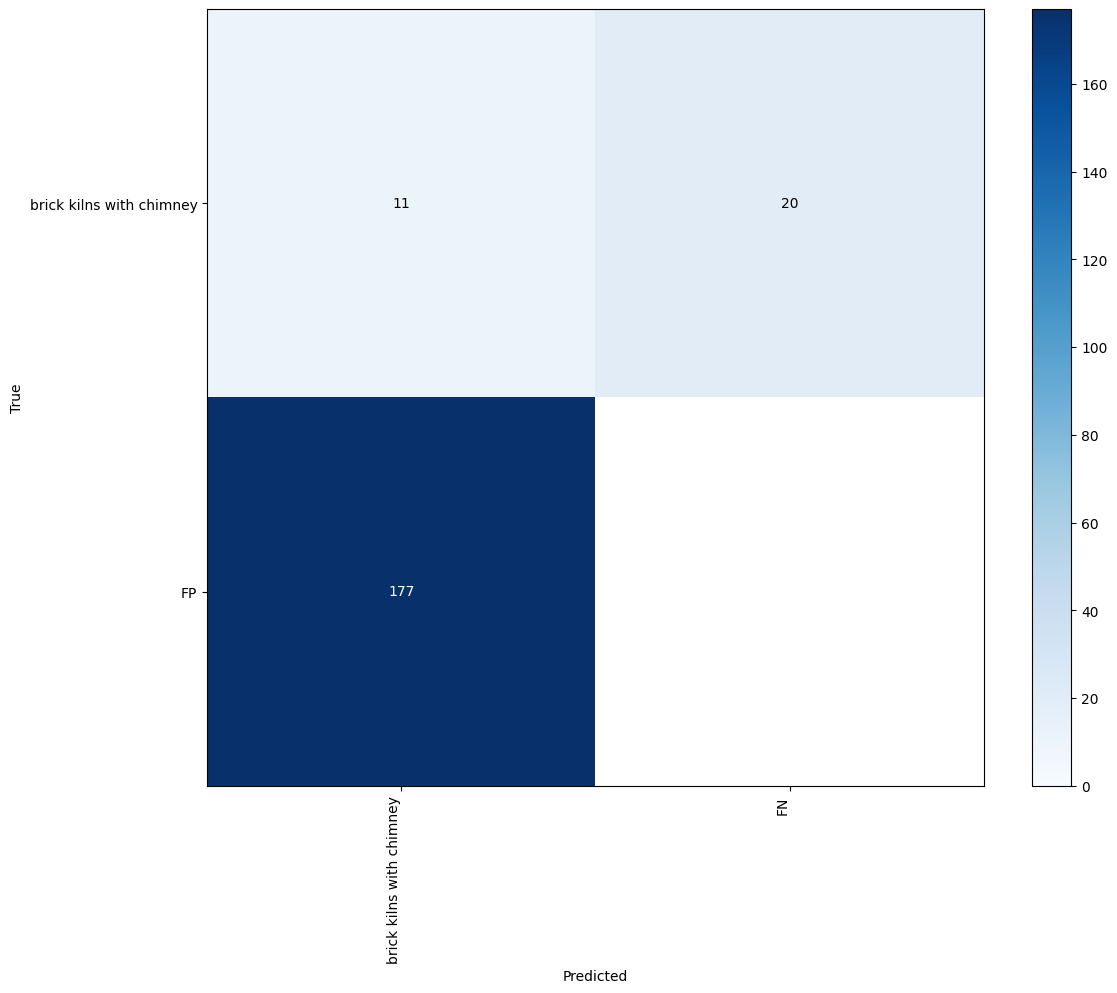

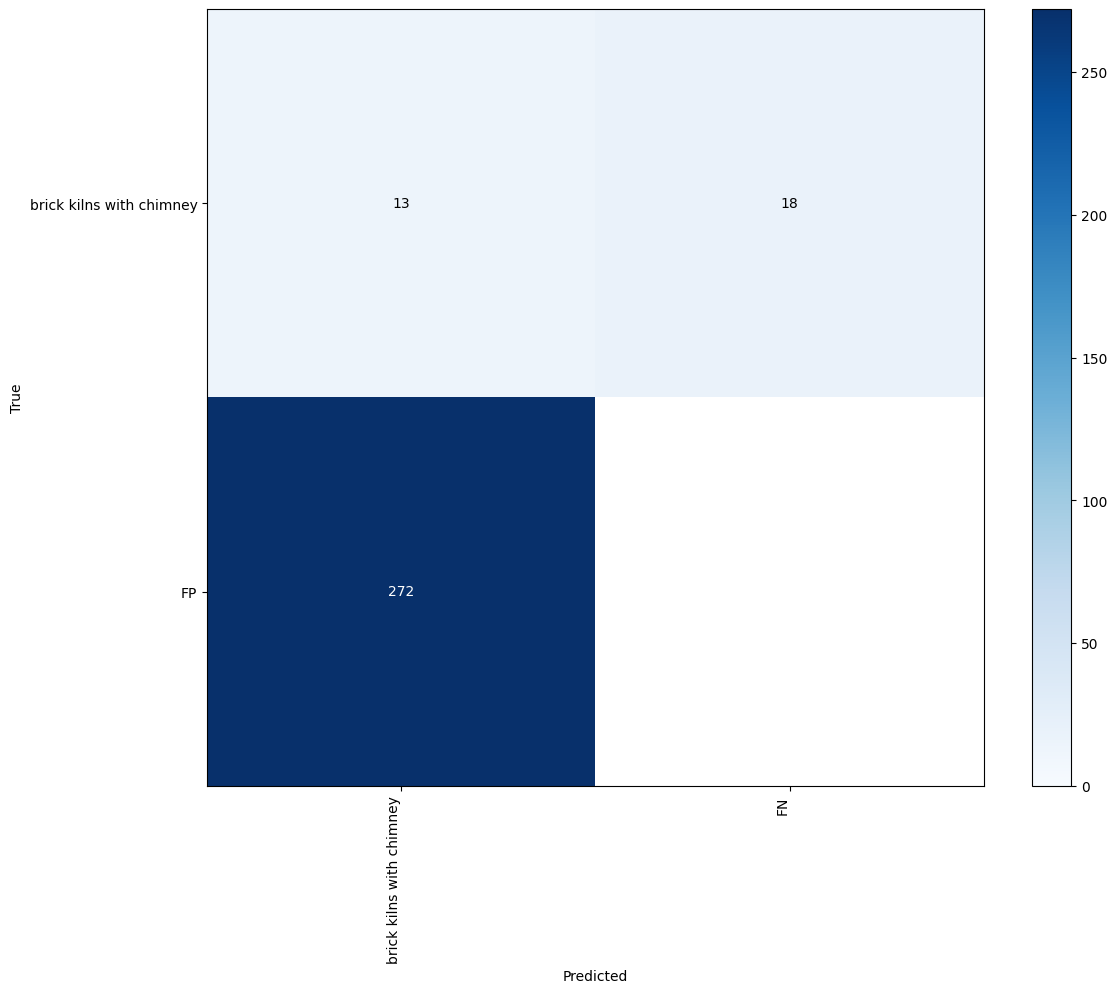

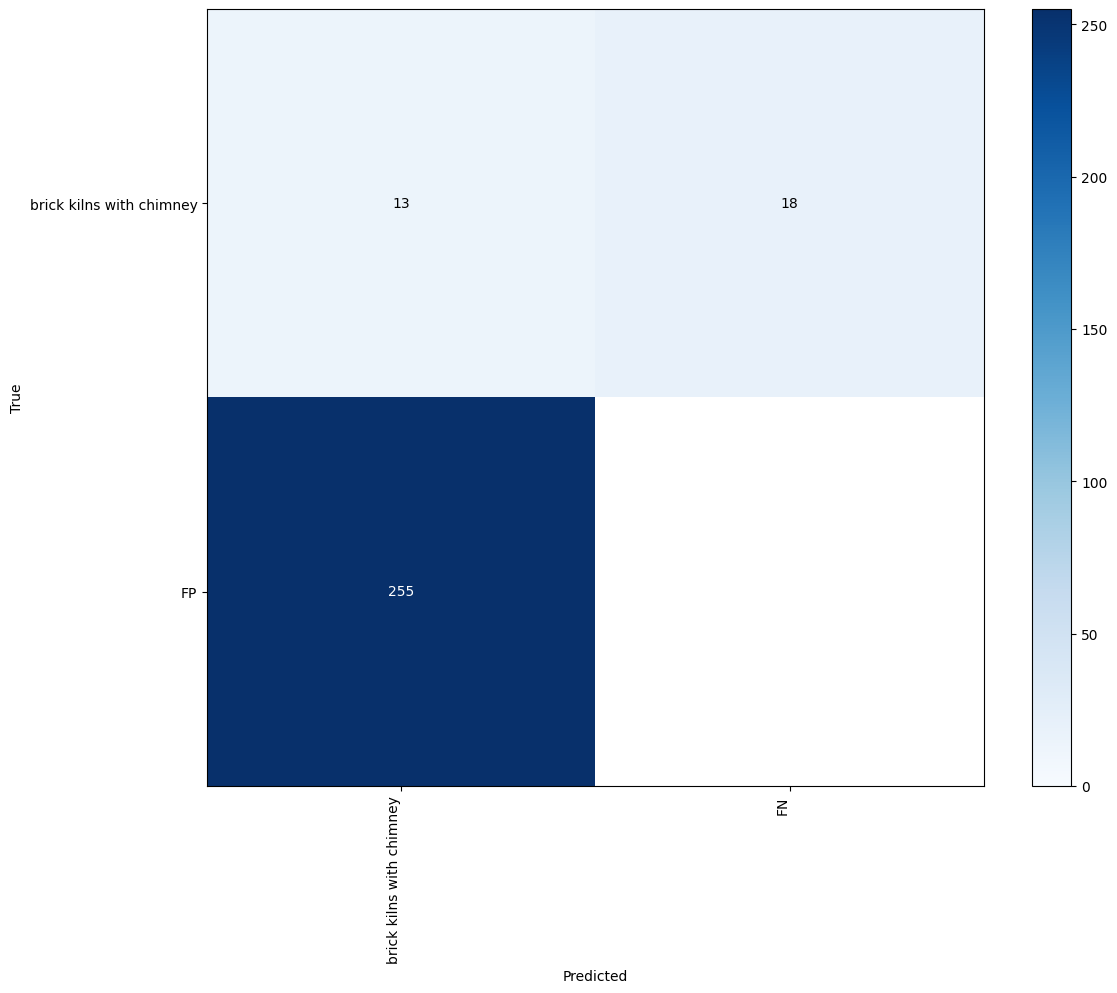

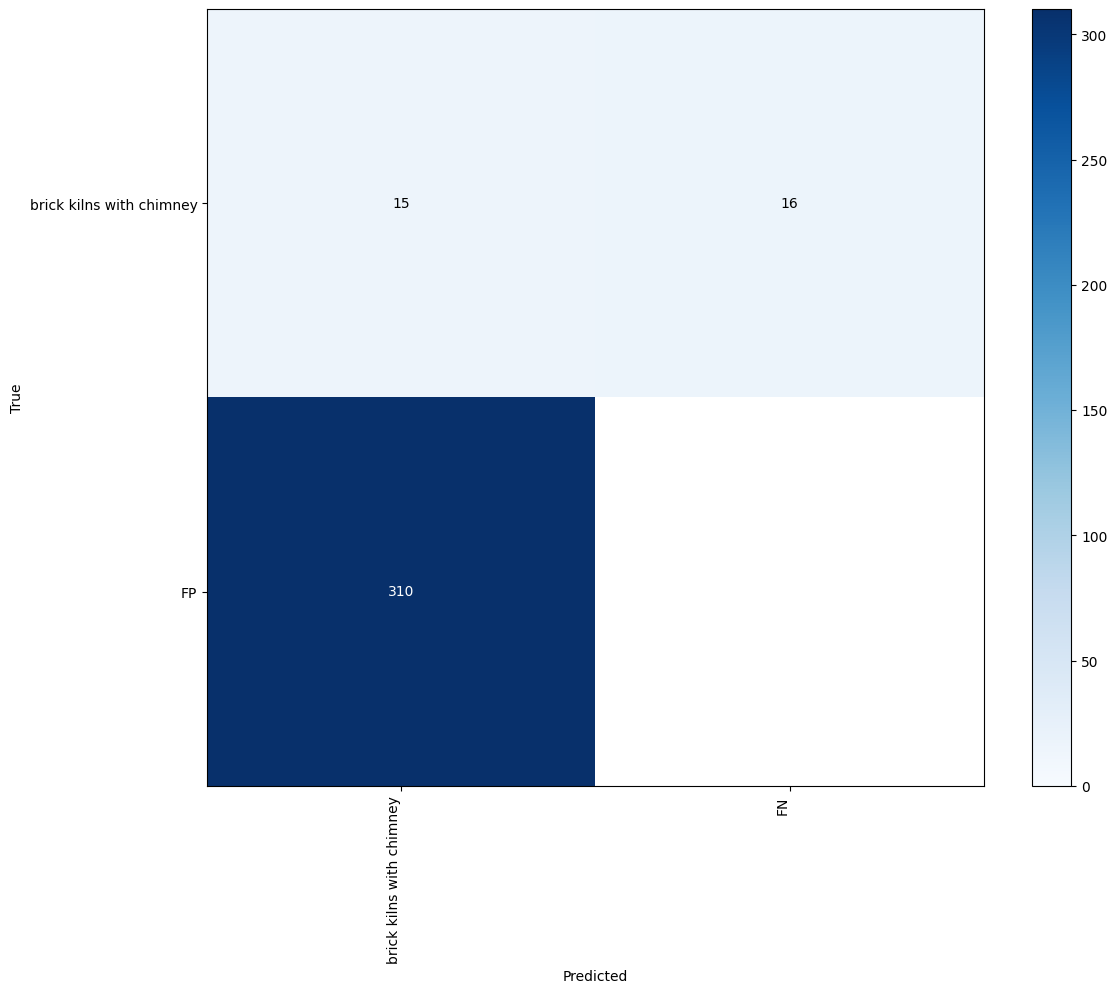

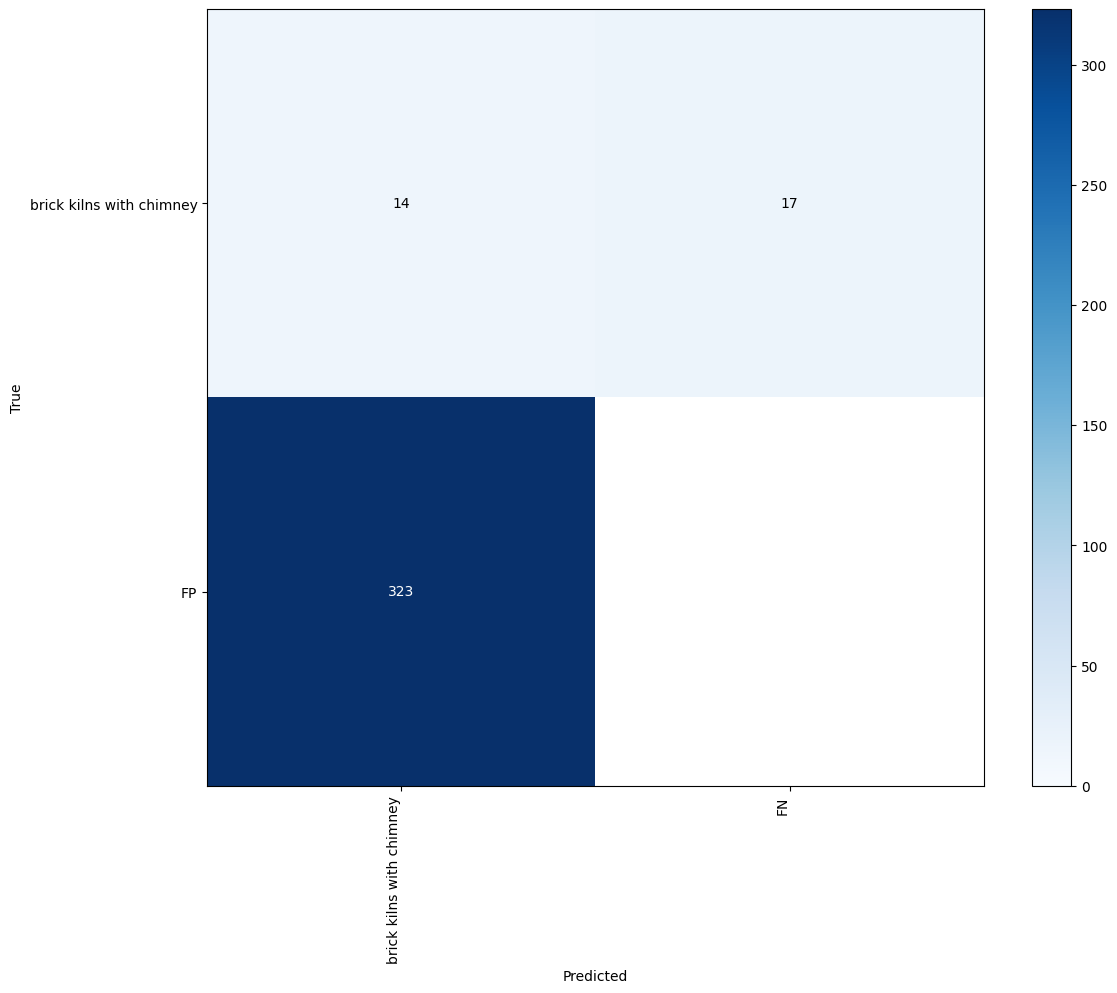

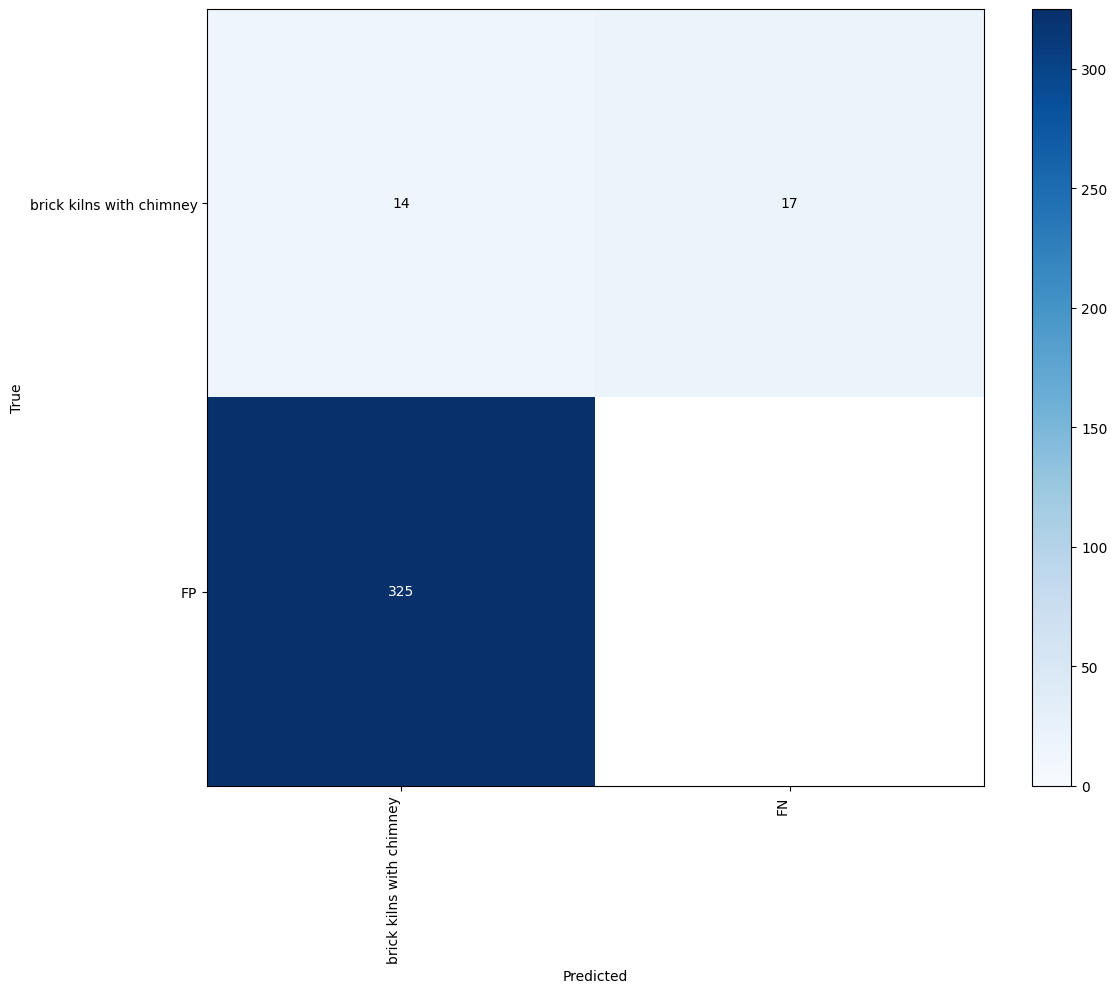

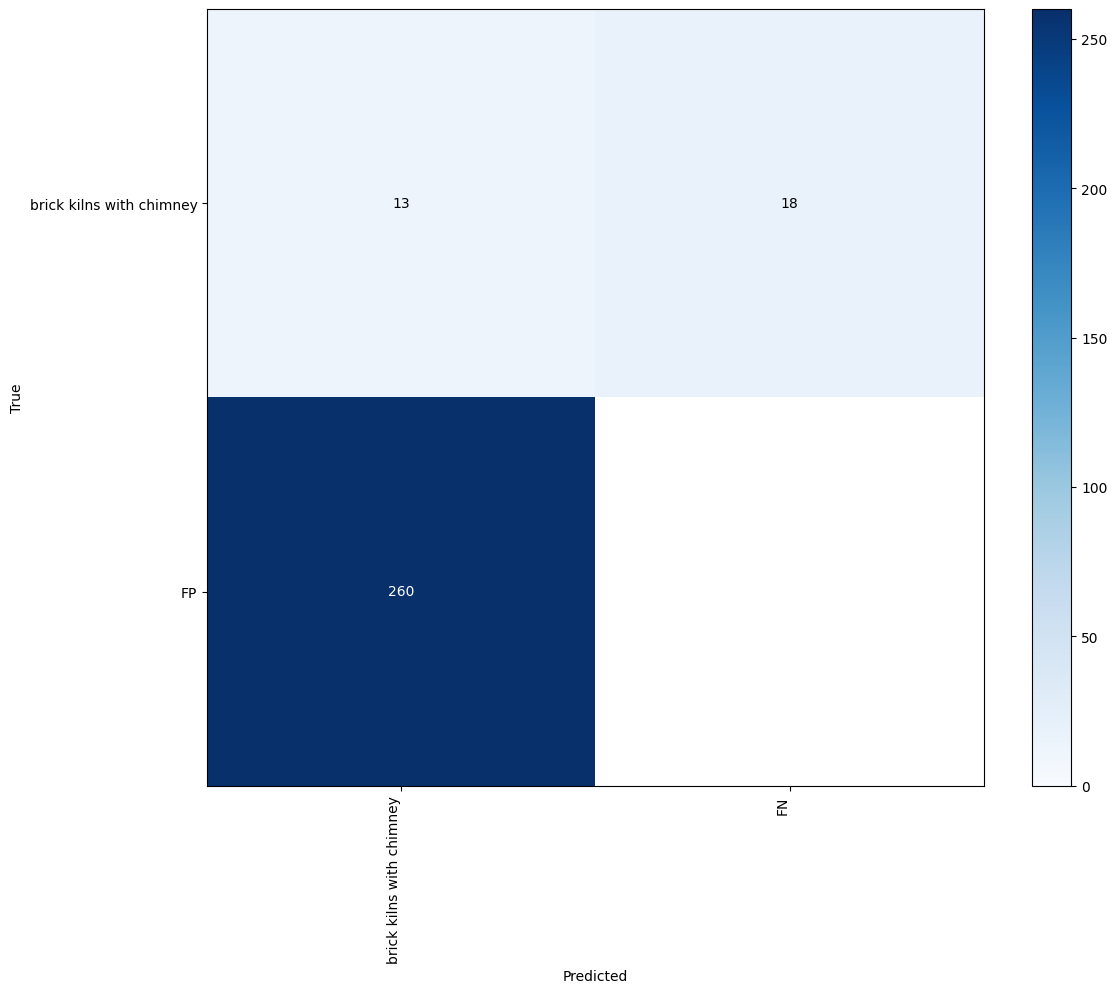

In [4]:
num_bg_image = 0
for num_non_bg_image in [1, 2, 3, 4, 5, 7, 10, 20, 30, 40, 60, 98]:

    create_train_directory(dynamic_dir, training_set_path, num_non_bg_image, num_bg_image, type)

    # SOURCE_IMAGE_PATHs = ["/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dynamic_lucknow_coco_train_test/train/8978754_3076282.tif"]
    # SOURCE_IMAGE_PATHs = ["/home/shataxi.dubey/shataxi_work/vlm_on_planet/train_superresolved/images/8978754_3076282.png"]
    # SOURCE_IMAGE_PATHs = ["/home/patel_zeel/kiln_compass_24/data/lucknow_airshed/images/9021406_3118628.tif"]
    # SOURCE_IMAGE_PATHs = ["/home/patel_zeel/kiln_compass_24/data/west_bengal/images/9850595_2774661.tif"]
    # SOURCE_IMAGE_PATHs = ["/home/patel_zeel/kiln_compass_24/data/uttar_pradesh/images/8652062_3224111.tif"]
    SOURCE_IMAGE_PATHs = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/images/*'))

    # label_dir = f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/train/labels'
    # label_dir = f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/lucknow_airshed_most_15/labels'
    # label_dir = f'/home/patel_zeel/kiln_compass_24/data/lucknow_airshed/labels'
    # label_dir = f'/home/patel_zeel/kiln_compass_24/data/west_bengal/labels'
    # label_dir = f'/home/patel_zeel/kiln_compass_24/data/uttar_pradesh/labels'
    label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/dynamic_train/labels'

    model_id = "yoloe-v8l-seg.pt"
    model, prompt = visual_prompting(model_id, SOURCE_IMAGE_PATHs, label_dir)

    # model = YOLOE("/home/shataxi.dubey/shataxi_work/vlm_on_planet/Yoloe/runs/lp/train/weights/best.pt").cuda()
    # model.set_classes(NAMES, model.get_text_pe(NAMES))

    targets = []
    predictions = []
    images = []

    for classes, image, gt_detection in sv_dataset:
        result = model.predict(image)
        detections = sv.Detections.from_ultralytics(result[0])
        detections = add_class_ids(detections, CLASSES, class_mapping)
        
        targets.append(gt_detection)
        predictions.append(detections)
        images.append(image)

    map_result, map_result_50, map_result_50_95 = calculate_map(predictions, targets)
    df = calculate_confusion_matrix(predictions, targets, CLASSES, map_result)
    print(f'Metrics from {num_non_bg_image} non background images and {num_bg_image} background images')
    display(df)
    # visualize_predictions(images, predictions, targets, start = 0, end = 25, rows = 5, cols = 5)

In [6]:
model.info()

YOLOe-v8l-seg summary: 461 layers, 53,471,638 parameters, 47,909,286 gradients, 223.0 GFLOPs


(461, 53471638, 47909286, 223.0266368)

In [11]:
prompt

{'bboxes': [array([[     77.537,      81.767,      193.59,      159.54]])],
 'cls': [array([0], dtype=int32)]}

#### Finetuning YOLOe is complex Ref: https://github.com/ultralytics/ultralytics/issues/20194#issuecomment-2845321118

In [ ]:
# from ultralytics import YOLOE
# from ultralytics.models.yolo.yoloe import YOLOEVPTrainer

# model = YOLOE("yoloe-11s-seg.pt")

# model.train(
#     data="yolo_data.yaml",
#     epochs=10,
#     close_mosaic=10,
#     batch=4,
#     optimizer="AdamW",
#     lr0=1e-3,
#     warmup_bias_lr=0.0,
#     weight_decay=0.025,
#     momentum=0.9,
#     workers=4,
#     device="0",
#     trainer=YOLOEVPTrainer,
# )
# # Run inference using text prompts ("person", "bus")
# model.set_classes(["brick kilns with chimney"])
# results = model.predict(source="/home/shataxi.dubey/shataxi_work/vlm_on_planet/gms/west_bengal_small_639_sq_km/kiln_images/test/images/9775572.7504_2537209.5122.png")
# results[0]  # save annotated output

New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.11.5 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
engine/trainer: task=segment, mode=train, model=yoloe-11s-seg.pt, data=yolo_data.yaml, epochs=10, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=False, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

AttributeError: 'str' object has no attribute 'get'

In [ ]:
# from glob import glob
# import supervision as sv


# # label_file = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels/*txt'))[9]
# # img_name = os.path.basename(label_file)[:-4]
# # TARGET_IMAGE_PATH = f"/home/shataxi.dubey/shataxi_work/vlm_on_planet/Florence-2/dynamic_lucknow_coco_train_test/test/{img_name}.tif"
# # TARGET_IMAGE_PATH = "/home/shataxi.dubey/shataxi_work/vlm_on_planet/test_superresolved/images/8982423_3141100.png"

# # Top 15 Planet images with maximum number of kilns
# # ['lucknow_airshed_most_15', 'west_bengal_most_15', 'uttar_pradesh_most_15']
# # location = 'lucknow_airshed_most_15'
# # TARGET_IMAGE_PATHS = sorted(glob(f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{location}/images/*'))
# # label_dir = f'/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/vlm_data/{location}/labels'

# # # Lucknow Images
# TARGET_IMAGE_PATHS = sorted(glob(f'/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/images/*'))
# label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/lucknow_train_test_split/test/labels'

# # West Bengal Images
# # TARGET_IMAGE_PATHS = sorted(glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/images/*'))
# # label_dir = '/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/wb_small_airshed/labels'

# targets = []
# predictions = []
# images = []

# for TARGET_IMAGE_PATH in TARGET_IMAGE_PATHS:
#     target_img_name = os.path.basename(TARGET_IMAGE_PATH)
#     if target_img_name.split('.')[1] != 'png' and target_img_name.split('.')[1] != 'jpg' and target_img_name.split('.')[1] != 'tif':
#         continue
#     print(f'Target image name {target_img_name}')
#     target_image = Image.open(TARGET_IMAGE_PATH)
#     images.append(target_image)
#     # img.save('target.jpg')
#     # TARGET_IMAGE_PATH = 'target.jpg'
#     # target_image = Image.open(TARGET_IMAGE_PATH)

#     results = model.predict(target_image)
#     detections = sv.Detections.from_ultralytics(results[0])
#     bbox = detections.xyxy
#     if len(bbox) == 0:
#         bbox = np.array([[0, 0, target_image.size[0], target_image.size[1], 1, 1]]) # xmin ymin xmax ymax class 1 conf 1 (background)
#     else:
#         bbox = np.hstack([bbox, np.zeros((len(bbox), 1)),  detections.confidence.reshape(-1,1)]) # xmin, ymin, xmax, ymax, class 0, conf 
#     predictions.append(bbox)

#     label_path = os.path.join(label_dir, target_img_name[:-3]+'txt')
#     if os.path.exists(label_path):
#         bbox = np.loadtxt(label_path, ndmin = 2)
#         bbox[:, 1:] = bbox[:, 1:]*target_image.size[0]
#         xmin, ymin = np.min(bbox[:,[1,3,5,7]], axis = 1), np.min(bbox[:, [2,4,6,8]], axis = 1) 
#         xmax, ymax = np.max(bbox[:,[1,3,5,7]], axis = 1), np.max(bbox[:, [2,4,6,8]], axis = 1)
#         bbox = np.array([xmin, ymin,xmax, ymax, np.zeros((len(bbox)))]) # xmin ymin xmax ymax class 0
#         bbox = bbox.T
#     else:
#         bbox = np.array([[0, 0, target_image.size[0], target_image.size[1], 1]]) # xmin ymin xmax ymax class 1 (background)
#     targets.append(bbox)

#     # annotated_image = target_image.copy()
#     # annotated_image = source_image.copy()
#     # annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
#     # annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

#     # annotated_image

Target image name 8978754_3075059.tif



0: 640x640 (no detections), 23.3ms
Speed: 2.9ms preprocess, 23.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Target image name 8978754_3087289.tif

0: 640x640 (no detections), 24.2ms
Speed: 1.7ms preprocess, 24.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Target image name 8978754_3097073.tif

0: 640x640 (no detections), 15.3ms
Speed: 2.7ms preprocess, 15.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Target image name 8978754_3108080.tif

0: 640x640 (no detections), 15.3ms
Speed: 1.7ms preprocess, 15.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Target image name 8978754_3110526.tif

0: 640x640 (no detections), 12.1ms
Speed: 1.7ms preprocess, 12.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Target image name 8978754_3111749.tif

0: 640x640 (no detections), 15.2ms
Speed: 1.7ms preprocess, 15.2ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Target image 

In [ ]:
# len(predictions), len(targets)

(649, 649)

In [ ]:
# num_non_bg_image, num_bg_image

(60, 30)

In [ ]:
# import pandas as pd
# df = pd.DataFrame({}, columns = ['IoU', 'Precision', 'Recall', 'F1 score', 'TP', 'FP', 'FN', 'Kiln instances'])
# for iou in [0.1,0.3,0.5,0.7]:
#     confusion_matrix = sv.ConfusionMatrix.from_tensors(predictions, targets, NAMES, conf_threshold=0.25, iou_threshold=iou)
#     cm = confusion_matrix.matrix
#     tp = cm[0][0]
#     predicted_positives = cm[:,0].sum()
#     actual_positives = cm[0, :].sum()
#     precision = tp/ (predicted_positives + 1e-9)
#     recall = tp/ (actual_positives + 1e-9)
#     f1_score = 2*precision*recall / (precision + recall +1e-9)
#     false_positives = predicted_positives - tp
#     df = pd.concat([df, pd.DataFrame({'IoU': iou, 'Precision': precision, 'Recall': recall, 'F1 score': f1_score, 'TP': tp, 'FP': false_positives, 'FN': actual_positives - tp, 'Kiln instances': actual_positives}, index = [0])])

# display(df)
# _ = confusion_matrix.plot()

In [ ]:
# useful_indices = []
# for idx, target in enumerate(targets):
#     if 0 in target[:, -1]:
#         useful_indices.append(idx)

In [14]:
# Image.open(SOURCE_IMAGE_PATH)

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize = (20,20),nrows = 5, ncols = 3)
# ax = ax.flatten()
# i = 0
# for j in useful_indices[:15]:
#     image = images[j]
#     detections = predictions[j]
#     ground_truths = targets[j]
#     ax[i].imshow(image)
#     for detection in detections:
#         ax[i].plot(detection[[0,2,2,0,0]], detection[[1,1,3,3,1]], color = 'red', linewidth = '4')
#     for ground_truth in ground_truths:
#         ax[i].plot(ground_truth[[0,2,2,0,0]], ground_truth[[1,1,3,3,1]], color = 'green', linewidth = '2')
#     ax[i].set_axis_off()
#     i += 1
# plt.tight_layout()
    

In [ ]:
# sum = 0
# for target in targets:
#     sum+= len(target)
# print(f'Total ground truth kilns {sum}')


# sum = 0
# for prediction in predictions:
#     sum += len(prediction)
# print(f'Total predicted kilns {sum}')

Total ground truth kilns 645
Total predicted kilns 524
